In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["TeX Gyre Termes", "Nimbus Roman", "Liberation Serif"]
plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "normal"


In [21]:
def get_feature_type(family):
    f = family.lower()
    if f.startswith("tfidf"):
        return "tfidf"
    elif f.startswith("fasttext"):
        return "fasttext"
    elif f.startswith("wfe"):
        return "wfe"
    elif f.startswith("wefe"):
        return "wefe"
    elif f.startswith("fe"):
        return "fe"
    elif f.startswith("we"):
        return "we"
    else:
        return "other"  # just in case

# FEATURES = ["fasttext", "we", "wfe", "wefe", "fe"]
FEATURES = ["fasttext", "we", "wefe", "fe"]
latex_labels = {
    "fasttext": r"$\mathcal{R}_\text{FT}$",
    "we": r"$\mathcal{R}_\text{S}$",
    "wefe": r"$\mathcal{R}_\text{H}$",
    "wfe": r"$\mathcal{R}_\text{D}$",
    "fe": r"$\mathcal{R}_\text{LLM}$"
}

In [22]:
SAVE_FOLDER = "./generated_figures"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [23]:
jsd = pd.read_csv("./generated/jetson/sentiment/merged/merged_only.csv")
jsd = jsd[jsd.FeatureFamily!='tfidf']
jsd['FeatureType'] = jsd['FeatureFamily'].apply(get_feature_type)
jsd['energy_per_sample'] = jsd['energy_per_sample']*3.6e6 # Joule
jsd['time_per_sample'] = jsd['time_per_sample']*1000 #  ms
jsd['EDP'] = jsd['time_per_sample'] * jsd['energy_per_sample']
jsd['FeatureType'].value_counts()

FeatureType
we          480
wefe        479
wfe         192
fe          192
fasttext     80
Name: count, dtype: int64

In [24]:
lsd = pd.read_csv("./generated/laptop/sentiment/merged/merged_only.csv")
lsd = lsd[lsd.FeatureFamily!='tfidf']
lsd['FeatureType'] = lsd['FeatureFamily'].apply(get_feature_type)
lsd['energy_per_sample'] = lsd['energy_per_sample']*3.6e6 # Joule
lsd['time_per_sample'] = lsd['time_per_sample']*1000 #  ms
lsd['EDP'] = lsd['time_per_sample'] * lsd['energy_per_sample']
lsd['FeatureType'].value_counts()

FeatureType
we          480
wefe        479
wfe         192
fe          192
fasttext     80
Name: count, dtype: int64

In [25]:
bsd = jsd[jsd.N_class == 2]
bsd = bsd.reset_index(drop=True)
bsd.tail()
tsd = jsd[jsd.N_class == 3]
tsd = tsd.reset_index(drop=True)
tsd.head()

,FeatureFamily,FeatureVariant,Dataset,N_class,Model,AccuracyTrain,WeightedF1Train,AccuracyTest,WeightedF1Test,TrainingTime,NumParams,NumEpochs,data_pts,time_sec,energy_kwh,throughput,time_per_sample,energy_per_sample,FeatureType,EDP
0,fasttext,mean,merged,3,LightGBM,0.886828,0.886812,0.717977,0.717439,214.111217,NaN,NaN,3000,108.731179,0.000222,27.590982,36.243726,0.266628,fasttext,9.663581
1,fasttext,mean,merged,3,LogisticRegression,0.649504,0.645245,0.648951,0.644675,148.928517,NaN,NaN,3000,102.984892,0.000209,29.130486,34.328297,0.251261,fasttext,8.625352
2,fasttext,mean,merged,3,RandomForest,0.966905,0.966894,0.683361,0.680761,181.504936,NaN,NaN,3000,110.357768,0.000222,27.184312,36.785923,0.266323,fasttext,9.796932
3,fasttext,mean,merged,3,XGBoost,0.733923,0.733209,0.698581,0.697630,37.603809,NaN,NaN,3000,102.263709,0.000207,29.335920,34.087903,0.248372,fasttext,8.466496
4,fasttext,mean,merged,3,GaussianNB,0.495744,0.491675,0.495971,0.491536,6.287981,NaN,NaN,3000,102.942328,0.000208,29.142531,34.314109,0.249509,fasttext,8.561667


## F1

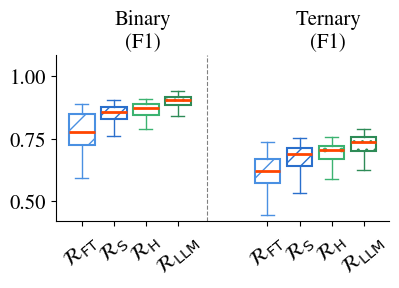

In [26]:
import matplotlib.pyplot as plt
import os

FONTSIZE = 15
CLS_TARGET = "WeightedF1Test"

data = []
labels = []

# Collect data from sources, only Binary and Ternary
sources = [bsd, tsd]
group_names = ["Binary\n(F1)", "Ternary\n(F1)"]

for source in sources:
    for feat in FEATURES:
        # Only include Binary and Ternary (assuming they correspond to first two groups)
        data.append(source[source["FeatureType"]==feat][CLS_TARGET])
        labels.append(latex_labels[feat])

# Colors and hatches per feature
feature_colors = ['#4A90E2', '#2A6FCC', '#3CB371', '#2E8B57', '#1E5F3C', '#9B59B6']
feature_hatches = ['/', '//', '.', '..', '...', 'xx']

BOX_WIDTH = 0.02
median_color = '#FF4500'
INTRA_GAP = 0.005
INTER_GAP = 0.05

# --- Compute positions ---
positions = []
group_boundaries = []
startpos = 0
n_features = len(FEATURES)

for g in range(len(group_names)):
    group_start = startpos
    for _ in range(n_features):
        positions.append(startpos)
        startpos += BOX_WIDTH + INTRA_GAP
    group_end = startpos - INTRA_GAP
    group_boundaries.append((group_start, group_end))
    startpos += INTER_GAP - INTRA_GAP

fig, ax = plt.subplots(figsize=(4,3))

# --- Plot boxes ---
for i, pos in enumerate(positions):
    arr = data[i]
    box = ax.boxplot(
        arr,
        positions=[pos],
        widths=BOX_WIDTH,
        patch_artist=True,
        showfliers=False
    )
    feature_idx = i % n_features
    color = feature_colors[feature_idx]
    hatch = feature_hatches[feature_idx]

    for patch in box['boxes']:
        patch.set(facecolor='none', hatch=hatch, edgecolor=color, linewidth=1.5)
    for whisker in box['whiskers']:
        whisker.set(color=color, linewidth=1)
    for cap in box['caps']:
        cap.set(color=color, linewidth=1)
    for median in box['medians']:
        median.set(color=median_color, linewidth=2, zorder=5)

# --- X-ticks ---
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=40, fontsize=FONTSIZE)
ax.tick_params(axis='y', labelsize=FONTSIZE)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Vertical separators ---
for start, end in group_boundaries[:-1]:
    ax.axvline(x=end + INTRA_GAP/2, color='gray', linestyle='--', linewidth=0.8)

# --- Add group labels ---
for i, (start, end) in enumerate(group_boundaries):
    mid = (start + end) / 2
    ax.text(mid, 1.02, group_names[i], ha='center', va='bottom', fontsize=FONTSIZE, transform=ax.get_xaxis_transform())

# --- Adjust x-limits and y-limits ---
margin = 0.02
ax.set_xlim(positions[0]-margin, positions[-1]+margin)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax*1.12)

plt.tight_layout()
plt.savefig(SAVE_FOLDER + os.sep + "merged_performance.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_469236/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_469236/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_469236/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_469236/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_469236/979093724.py:70: UserWarning: set_ticklabels() should only be used with a fixed number

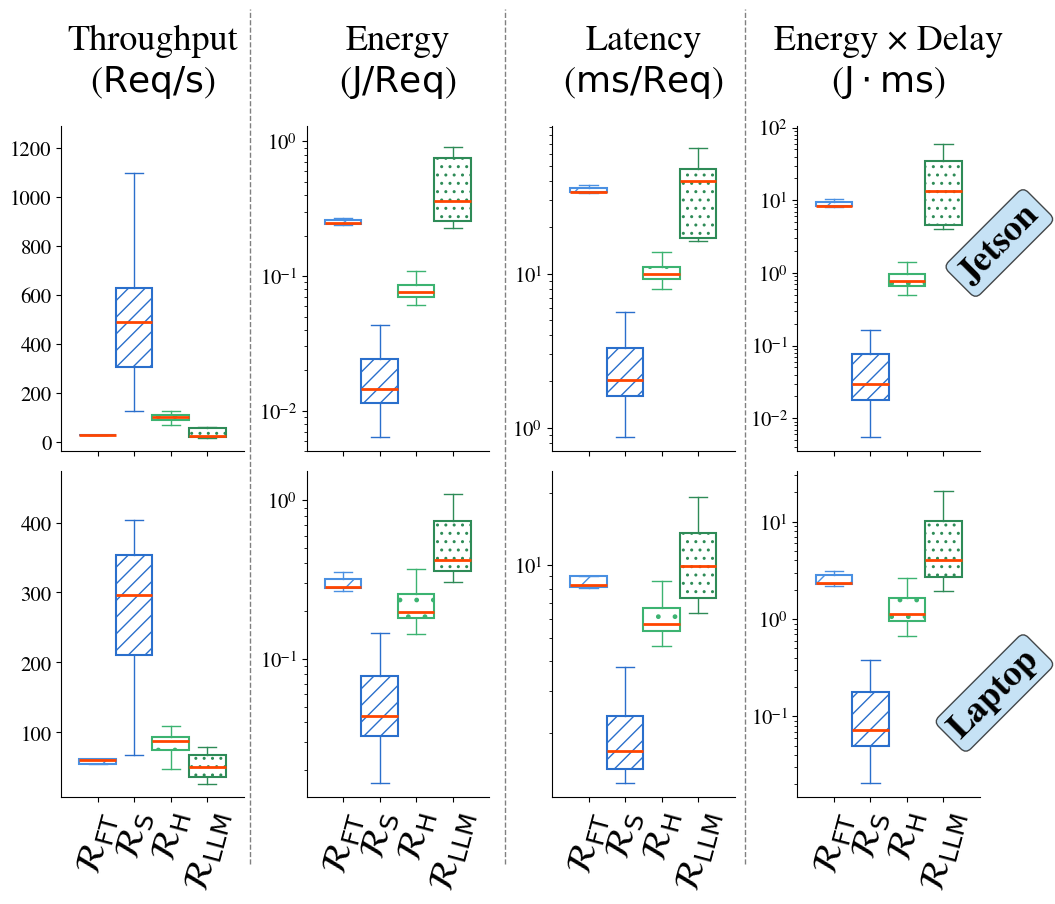

In [27]:
import matplotlib.pyplot as plt
from collections import defaultdict
import os

FONTSIZE = 26
BOX_WIDTH = 0.02
median_color = '#FF4500'
INTRA_GAP = 0.00
LABEL_BOX_COLOR = "#AED6F1"  # Light blue rectangle
LABEL_BOX_OPACITY = 0.7

metrics = [
    ("throughput", "Throughput\n($\\mathrm{Req}/\\mathrm{s}$)", False),
    ("energy_per_sample", "Energy\n($\\mathrm{J}/\\mathrm{Req}$)", True),
    ("time_per_sample", "Latency\n($\\mathrm{ms}/\\mathrm{Req}$)", True),
    ("EDP", "Energy × Delay\n($\\mathrm{J}\\cdot\\mathrm{ms}$)", True)
]

feature_colors = ['#4A90E2', '#2A6FCC', '#3CB371', '#2E8B57', '#1E5F3C', '#9B59B6']
feature_hatches = ['/', '//', '.', '..', '...', 'xx']

fig, axes = plt.subplots(2, 4, figsize=(10, 9), sharex=True)
fig.subplots_adjust(wspace=0.4, hspace=0.5)  # spacing between subplots

def plot_row(ax_row, sources):
    for ax, (CLS_TARGET, ylabel, logscale) in zip(ax_row, metrics):
        data = defaultdict(list)
        for source in sources:
            for feat in FEATURES:
                dt = source[source["FeatureType"] == feat][CLS_TARGET]
                data[feat].extend(dt)

        labels = [latex_labels[t] for t in data.keys()]
        data_list = list(data.values())

        positions = []
        startpos = 0
        for _ in range(len(FEATURES)):
            positions.append(startpos)
            startpos += BOX_WIDTH + INTRA_GAP

        for i, pos in enumerate(positions):
            arr = data_list[i]
            box = ax.boxplot(
                arr,
                positions=[pos],
                widths=BOX_WIDTH,
                patch_artist=True,
                showfliers=False
            )

            feature_idx = i % len(FEATURES)
            color = feature_colors[feature_idx]
            hatch = feature_hatches[feature_idx]

            for patch in box['boxes']:
                patch.set(facecolor='none', hatch=hatch, edgecolor=color, linewidth=1.5)
            for whisker in box['whiskers']:
                whisker.set(color=color, linewidth=1)
            for cap in box['caps']:
                cap.set(color=color, linewidth=1)
            for median in box['medians']:
                median.set(color=median_color, linewidth=2, zorder=5)

        if logscale:
            ax.set_yscale('log')

        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=75, fontsize=FONTSIZE)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.12)
        margin = 0.02
        ax.set_xlim(positions[0] - margin, positions[-1] + margin)

# Plot first row: Jetson
plot_row(axes[0], [jsd])
# Plot second row: Laptop
plot_row(axes[1], [lsd])

# Add metric names as column headers on top row
for col in range(4):
    axes[0, col].set_title(metrics[col][1], fontsize=FONTSIZE, pad=25)  # pad moves it above plots

# Add vertical dashed lines between columns
from matplotlib.lines import Line2D

# Example tunable coordinates
# You can adjust these numbers between 0 and 1 to move lines
x_fracs = [0.255, 0.51, 0.75]   # x positions between columns
y_bottom_frac = 0.05            # bottom of dashed line
y_top_frac = 1               # top of dashed line

for x0 in x_fracs:
    line = Line2D([x0, x0], [y_bottom_frac, y_top_frac], transform=fig.transFigure,
                  color='gray', linestyle='--', linewidth=1)
    fig.add_artist(line)
# Text for each row
row_texts_left = ["Jetson", "Laptop"]   # left side

# Adjust the y positions for each row (0 = bottom, 1 = top)
y_positions = [0.78, 0.28]  # approximate vertical center of each row

for i, y in enumerate(y_positions):
    # Left side text
    # fig.text(-0.01, y, row_texts_left[i], fontsize=FONTSIZE, va='center', ha='left', fontweight='bold', rotation=90)
    # Right side text
    fig.text(1.05, y-0.04, row_texts_left[i], fontsize=FONTSIZE, va='center', ha='right', fontweight='bold', rotation=45,bbox=dict(facecolor=LABEL_BOX_COLOR, alpha=LABEL_BOX_OPACITY, edgecolor='black', boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.savefig(SAVE_FOLDER + os.sep + "merged_efficiency_boxplots.pdf",
            format='pdf', bbox_inches='tight')
plt.show()


In [28]:
import pandas as pd
import numpy as np

# ---------------------------
# Config
# ---------------------------
DEVICES = {
    "Jetson": jsd,
    "Laptop": lsd
}
TASK_CLASS = None
BASELINE = "fasttext"
METRICS = ["time_per_sample", "energy_per_sample", "EDP", "throughput"]

# ---------------------------
# Compute relative metrics per device
# ---------------------------
def compute_relative_metrics(df, baseline=BASELINE, n_class=None):
    relative = {}
    for m in FEATURES:
        mask = df["FeatureType"] == m
        if n_class is not None:
            mask &= df["N_class"] == n_class
        
        median_latency = df.loc[mask, "time_per_sample"].median()
        median_energy  = df.loc[mask, "energy_per_sample"].median()
        median_edp     = df.loc[mask, "EDP"].median()
        median_throughput = df.loc[mask, "throughput"].median()
        
        relative[m] = {
            "latency": median_latency,
            "energy": median_energy,
            "EDP": median_edp,
            "throughput": median_throughput
        }
    
    # Normalize vs baseline
    baseline_vals = relative[baseline]
    for m in FEATURES:
        relative[m]["speedup_latency"] = baseline_vals["latency"] / relative[m]["latency"]
        relative[m]["energy_reduction"] = baseline_vals["energy"] / relative[m]["energy"]
        relative[m]["EDP_reduction"] = baseline_vals["EDP"] / relative[m]["EDP"]
        relative[m]["throughput_gain"] = relative[m]["throughput"] / baseline_vals["throughput"]
    
    return relative

# ---------------------------
# Build merged table with interleaved subcolumns
# ---------------------------
rows = []
metrics_order = [
    ("speedup_latency", "Latency Speedup"),
    ("throughput_gain", "Throughput Gain"),
    ("energy_reduction", "Energy Reduction"),
    ("EDP_reduction", "EDP Reduction"),
]

for method in FEATURES:
    row = {"Method": method}
    # Compute per-device metrics first
    rels = {device_name: compute_relative_metrics(df, baseline=BASELINE, n_class=TASK_CLASS)[method]
            for device_name, df in DEVICES.items()}
    
    # Interleave device values per metric
    for metric_key, metric_label in metrics_order:
        for device_name in DEVICES.keys():
            row[f"{metric_label} ({device_name} ×)"] = rels[device_name][metric_key]
    rows.append(row)

rel_table = pd.DataFrame(rows)
rel_table = rel_table.round(2)
rel_table


,Method,Latency Speedup (Jetson ×),Latency Speedup (Laptop ×),Throughput Gain (Jetson ×),Throughput Gain (Laptop ×),Energy Reduction (Jetson ×),Energy Reduction (Laptop ×),EDP Reduction (Jetson ×),EDP Reduction (Laptop ×)
0,fasttext,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,we,16.79,4.90,16.79,4.90,16.96,6.49,287.25,31.82
2,wefe,3.41,1.44,3.41,1.44,3.25,1.43,11.03,2.05
3,fe,0.86,0.83,0.86,0.83,0.68,0.68,0.63,0.57


In [29]:
baseline = bsd[bsd.FeatureType == 'fe']['WeightedF1Test'].median()
we = bsd[bsd.FeatureType == 'we']['WeightedF1Test'].median()
wefe = bsd[bsd.FeatureType == 'wefe']['WeightedF1Test'].median()
fasttext = bsd[bsd.FeatureType == 'fasttext']['WeightedF1Test'].median()

In [30]:
100.0*(fasttext - baseline)/baseline, 100.0*(we - baseline)/baseline, 100.0*(wefe - baseline)/baseline

(-13.961434546432852, -5.314396416562055, -3.611551953866008)

In [31]:
baseline = tsd[tsd.FeatureType == 'fe']['WeightedF1Test'].median()
we = tsd[tsd.FeatureType == 'we']['WeightedF1Test'].median()
wefe = tsd[tsd.FeatureType == 'wefe']['WeightedF1Test'].median()
fasttext = tsd[tsd.FeatureType == 'fasttext']['WeightedF1Test'].median()

In [32]:
100.0*(fasttext - baseline)/baseline, 100.0*(we - baseline)/baseline, 100.0*(wefe - baseline)/baseline

(-15.811673601229023, -6.548724837840819, -4.683036311784776)

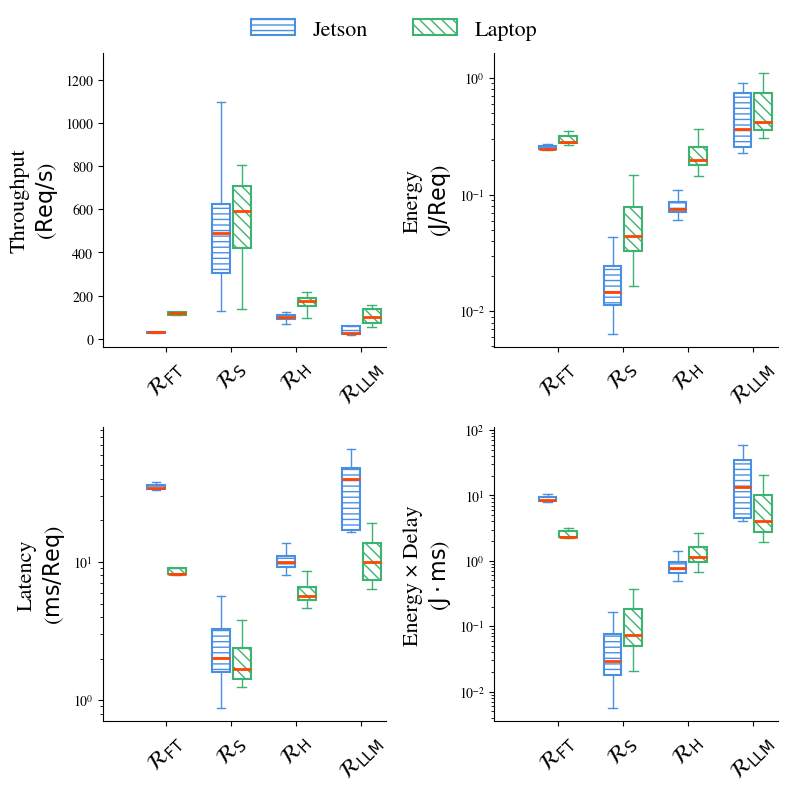

In [33]:
import matplotlib.pyplot as plt
from collections import defaultdict
import os

FONTSIZE = 16
BOX_WIDTH = 0.3
median_color = '#FF4500'

metrics = [
    ("throughput", "Throughput\n($\\mathrm{Req}/\\mathrm{s}$)", False),
    ("energy_per_sample", "Energy\n($\\mathrm{J}/\\mathrm{Req}$)", True),
    ("time_per_sample", "Latency\n($\\mathrm{ms}/\\mathrm{Req}$)", True),
    ("EDP", "Energy × Delay\n($\\mathrm{J}\\cdot\\mathrm{ms}$)", True)
]

device_labels = ["Jetson", "Laptop"]
device_sources = [[jsd], [lsd]]
device_colors = ['#4A90E2', '#3CB371']   # Jetson blue, Laptop green
device_hatches = ['---', '\\\\\\']           # hatch styles

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
fig.subplots_adjust(wspace=0.3, hspace=0.4)


def plot_metric(ax, metric_key, ylabel, logscale):
    positions = []
    labels = []
    data_groups = []
    # integer tick for each feature group
    group_centers = list(range(len(FEATURES)))
    offset = 0.2   # horizontal shift left/right for Jetson vs Laptop

    startpos = 0
    group_gap = 0.4   # gap between feature groups
    intra_gap = 0.05   # spacing between Jetson & Laptop

    for feat in FEATURES:
        for d_idx, sources in enumerate(device_sources):
            arr = []
            for source in sources:
                dt = source[source["FeatureType"] == feat][metric_key]
                arr.extend(dt)
            data_groups.append((d_idx, arr))

            pos = startpos + (d_idx * (BOX_WIDTH + intra_gap))
            positions.append(pos)
            labels.append(latex_labels[feat] if d_idx == 0 else "")

        startpos += 2 * (BOX_WIDTH + intra_gap) + group_gap

    # Plot
    for (d_idx, arr), pos in zip(data_groups, positions):
        box = ax.boxplot(
            arr,
            positions=[pos],
            widths=BOX_WIDTH,
            patch_artist=True,
            showfliers=False
        )
        color = device_colors[d_idx]
        hatch = device_hatches[d_idx]
        for patch in box['boxes']:
            patch.set(facecolor='none', hatch=hatch, edgecolor=color, linewidth=1.5)
        for whisker in box['whiskers']:
            whisker.set(color=color, linewidth=1)
        for cap in box['caps']:
            cap.set(color=color, linewidth=1)
        for median in box['medians']:
            median.set(color=median_color, linewidth=2, zorder=5)

    if logscale:
        ax.set_yscale('log')

    ax.set_ylabel(ylabel, fontsize=FONTSIZE)
    ax.set_xticks([positions[i] + (positions[i+1]-positions[i])/2 for i in range(0, len(positions), 2)])
    ax.set_xticklabels([latex_labels[f] for f in FEATURES], fontsize=FONTSIZE, rotation=45)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 🚩 compact horizontally
    margin = 0.9   # small margin around groups
    ax.set_xlim(group_centers[0] - margin, group_centers[-1]+margin)


# Plot each metric into its subplot
for ax, (metric_key, ylabel, logscale) in zip(axes, metrics):
    plot_metric(ax, metric_key, ylabel, logscale)
    # ax.set_title(ylabel, fontsize=FONTSIZE, pad=15)

# Legend (devices)
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor='none', edgecolor=color, hatch=h, label=lab, linewidth=1.5)
                  for color, h, lab in zip(device_colors, device_hatches, device_labels)]
fig.legend(handles=legend_handles, loc="upper center", ncol=2, fontsize=FONTSIZE, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.savefig(SAVE_FOLDER + os.sep + "merged_efficiency_boxplots_v2.pdf",
            format='pdf', bbox_inches='tight')
plt.show()


# TABLE DATA

### JETSON

In [34]:
ALL_STAT = ["time_per_sample", "throughput", "EDP", "energy_per_sample"]
ALL_STAT = ALL_STAT[::-1]
for METHOD in ALL_STAT:
    print(METHOD)
    baseline = None   
    for FEAT in FEATURES:
        # Combine the two lists
        # print(FEAT, METHOD)
        tt = list(jsd[jsd.FeatureType == FEAT][METHOD])
    
    
        
        # Convert to numpy array for convenience
        tt_array = np.array(tt)
        
        # Compute statistics
        p5 = np.percentile(tt_array, 5)
        q1 = np.percentile(tt_array, 25)
        median = np.median(tt_array)
        q3 = np.percentile(tt_array, 75)
        p95 = np.percentile(tt_array, 95)
        
        times = None
        if not baseline:
            baseline = median
        if METHOD == 'throughput':
            times = median/baseline
        else:
            times = baseline/median
        # print(median,baseline)
        print(f"{latex_labels[FEAT]} & {p5:.3f} & {q1:.2f} & {median:.2f} & {q3:.2f} & {p95:.2f} & {times:.2f} \\\\ % min={np.min(tt_array):.2f} max={np.max(tt_array):.2f}")
        # print(f"Min: {min_val}")
        # print(f"Q1: {q1}")
        # print(f"Median: {median}")
        # print(f"Q3: {q3}")
        # print(f"Max: {max_val}")

energy_per_sample
$\mathcal{R}_\text{FT}$ & 0.242 & 0.24 & 0.25 & 0.26 & 0.40 & 1.00 \\ % min=0.24 max=0.41
$\mathcal{R}_\text{S}$ & 0.008 & 0.01 & 0.01 & 0.02 & 0.06 & 16.96 \\ % min=0.01 max=0.07
$\mathcal{R}_\text{H}$ & 0.063 & 0.07 & 0.08 & 0.09 & 0.13 & 3.25 \\ % min=0.06 max=0.15
$\mathcal{R}_\text{LLM}$ & 0.238 & 0.26 & 0.36 & 0.75 & 0.89 & 0.68 \\ % min=0.23 max=0.91
EDP
$\mathcal{R}_\text{FT}$ & 8.085 & 8.26 & 8.44 & 9.38 & 16.98 & 1.00 \\ % min=8.02 max=17.64
$\mathcal{R}_\text{S}$ & 0.010 & 0.02 & 0.03 & 0.08 & 0.27 & 287.25 \\ % min=0.01 max=0.58
$\mathcal{R}_\text{H}$ & 0.555 & 0.66 & 0.77 & 0.97 & 1.48 & 11.03 \\ % min=0.50 max=2.16
$\mathcal{R}_\text{LLM}$ & 4.193 & 4.57 & 13.32 & 34.17 & 55.87 & 0.63 \\ % min=4.08 max=59.92
throughput
$\mathcal{R}_\text{FT}$ & 23.510 & 27.64 & 29.27 & 29.61 & 29.91 & 1.00 \\ % min=23.08 max=30.06
$\mathcal{R}_\text{S}$ & 204.869 & 305.74 & 491.39 & 626.99 & 894.66 & 16.79 \\ % min=127.81 max=1148.97
$\mathcal{R}_\text{H}$ & 79.836 & 90.

### LAPTOP

In [35]:
ALL_STAT = ["time_per_sample", "throughput", "EDP", "energy_per_sample"]
ALL_STAT = ALL_STAT[::-1]
for METHOD in ALL_STAT:
    print(METHOD)
    baseline = None   
    for FEAT in FEATURES:
        # Combine the two lists
        # print(FEAT, METHOD)
        tt = list(lsd[lsd.FeatureType == FEAT][METHOD])
    
    
        
        # Convert to numpy array for convenience
        tt_array = np.array(tt)
        
        # Compute statistics
        p5 = np.percentile(tt_array, 5)
        q1 = np.percentile(tt_array, 25)
        median = np.median(tt_array)
        q3 = np.percentile(tt_array, 75)
        p95 = np.percentile(tt_array, 95)
        
        times = None
        if not baseline:
            baseline = median
        if METHOD == 'throughput':
            times = median/baseline
        else:
            times = baseline/median
        # print(median,baseline)
        print(f"{latex_labels[FEAT]} & {p5:.3f} & {q1:.2f} & {median:.2f} & {q3:.2f} & {p95:.2f} & {times:.2f} \\\\ % min={np.min(tt_array):.2f} max={np.max(tt_array):.2f}")
        # print(f"Min: {min_val}")
        # print(f"Q1: {q1}")
        # print(f"Median: {median}")
        # print(f"Q3: {q3}")
        # print(f"Max: {max_val}")

energy_per_sample
$\mathcal{R}_\text{FT}$ & 0.274 & 0.28 & 0.28 & 0.32 & 1.86 & 1.00 \\ % min=0.27 max=2.00
$\mathcal{R}_\text{S}$ & 0.021 & 0.03 & 0.04 & 0.08 & 0.34 & 6.49 \\ % min=0.02 max=0.62
$\mathcal{R}_\text{H}$ & 0.164 & 0.18 & 0.20 & 0.26 & 1.08 & 1.43 \\ % min=0.14 max=1.24
$\mathcal{R}_\text{LLM}$ & 0.321 & 0.36 & 0.42 & 0.74 & 0.97 & 0.68 \\ % min=0.31 max=1.10
EDP
$\mathcal{R}_\text{FT}$ & 2.228 & 2.28 & 2.33 & 2.84 & 38.56 & 1.00 \\ % min=2.20 max=45.55
$\mathcal{R}_\text{S}$ & 0.028 & 0.05 & 0.07 & 0.18 & 1.41 & 31.82 \\ % min=0.02 max=4.56
$\mathcal{R}_\text{H}$ & 0.824 & 0.97 & 1.13 & 1.65 & 13.55 & 2.05 \\ % min=0.66 max=18.40
$\mathcal{R}_\text{LLM}$ & 2.197 & 2.73 & 4.09 & 10.15 & 17.03 & 0.57 \\ % min=1.94 max=20.84
throughput
$\mathcal{R}_\text{FT}$ & 47.906 & 110.62 & 121.14 & 122.77 & 124.23 & 1.00 \\ % min=43.95 max=124.67
$\mathcal{R}_\text{S}$ & 233.184 & 422.46 & 593.54 & 708.08 & 754.08 & 4.90 \\ % min=135.76 max=807.40
$\mathcal{R}_\text{H}$ & 79.579 & 15